In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn import linear_model as lm
from sklearn.metrics import explained_variance_score, mean_squared_error
import itertools
cwd = os.getcwd()
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# Add directories for modules and data files
dirs = [x[0] for x in os.walk(cwd)]
[sys.path.append(d) for d in dirs]
data_dir = cwd+'\\Input\\DataFiles\\' # Manual way; TODO: find a relative way to do this automatically
vegas_dir = cwd+'\\Input\\VegasOdds\\'
elo_out_dir = cwd+'\\Output\\TestElos\\'
import elo

In [2]:
p = Path('.')
paths = list(p.glob('**/*.csv'))
paths


#params = list(itertools.product(Ks, HCAs))

[WindowsPath('odds_2017_basic.csv'),
 WindowsPath('Input/DataFiles/Cities.csv'),
 WindowsPath('Input/DataFiles/ConferenceTourneyGames.csv'),
 WindowsPath('Input/DataFiles/EloHistory.csv'),
 WindowsPath('Input/DataFiles/GameCities.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyDetailedResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySeeds.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySlots.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonCompactResults.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonDetailedResults.csv'),
 WindowsPath('Input/DataFiles/SeasonElos.csv'),
 WindowsPath('Input/DataFiles/SeasonElosK25.csv'),
 WindowsPath('Input/DataFiles/Seasons.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyTeams.csv'),
 WindowsPath('Input/DataFiles/TeamCoaches.csv'),
 WindowsPath('Input/DataFiles/Teams.csv'),
 WindowsPath('Input/DataFiles/Team

In [3]:
cwd

'C:\\Users\\ramir\\OneDrive\\Documents\\GitHub\\Springboard-Data-Science\\NCAABBPrediction'

In [4]:
start = 2003
rs_c = pd.read_csv(data_dir+'RegularSeasonCompactResults.csv')
rs_c = rs_c.loc[rs_c.Season>=start]
rs_c = rs_c.drop(['NumOT'], axis=1)
rs_c = rs_c.reset_index(drop=True)
rs_c.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc
82036,2018,132,1153,56,1222,55,N
82037,2018,132,1172,58,1348,57,N
82038,2018,132,1209,74,1426,61,N
82039,2018,132,1246,77,1397,72,N
82040,2018,132,1335,68,1217,65,N


In [5]:
rs_c.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc
0,2003,10,1104,68,1328,62,N
1,2003,10,1272,70,1393,63,N
2,2003,11,1266,73,1437,61,N
3,2003,11,1296,56,1457,50,N
4,2003,11,1400,77,1208,71,N


In [6]:
tourney_cr = pd.read_csv(data_dir+'NCAATourneyCompactResults.csv')
tourney_cr.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_cr = tourney_cr[tourney_cr.Season >= start]
tourney_cr['WMargin'] = tourney_cr.WScore - tourney_cr.LScore
tourney_cr = tourney_cr.reset_index(drop=True)
tourney_cr.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
1043,2018,146,1437,71,1403,59,12
1044,2018,146,1242,85,1181,81,4
1045,2018,152,1276,69,1260,57,12
1046,2018,152,1437,95,1242,79,16
1047,2018,154,1437,79,1276,62,17


In [7]:
elos, preds = elo.season_elos(rs=rs_c)

In [8]:
elos.head()

,Season,SeasonElo,TeamID
57902,2014,1408.07,1101
62101,2015,1294.42,1101
68675,2016,1210.1,1101
72986,2017,1238.19,1101
81712,2018,1293.61,1101


In [9]:
elos.tail()

,Season,SeasonElo,TeamID
56457,2014,1455.25,1464
61343,2015,1420.25,1464
66937,2016,1361.7,1464
72302,2017,1334.43,1464
81686,2018,1255.5,1464


In [10]:
sns.set(font_scale=1.5)
elos_tourney = elo.winloss_features(df_teams=tourney_cr, df_feature=elos, feature_cols=['SeasonElo'])
elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
1042,2018,146,1437,71,1403,59,12,2090.45,1834.38,256.073171
1043,2018,146,1242,85,1181,81,4,1994.26,2010.47,-16.203821
1044,2018,152,1276,69,1260,57,12,1950.42,1728.59,221.831858
1045,2018,152,1437,95,1242,79,16,2090.45,1994.26,96.186820
1046,2018,154,1437,79,1276,62,17,2090.45,1950.42,140.027477


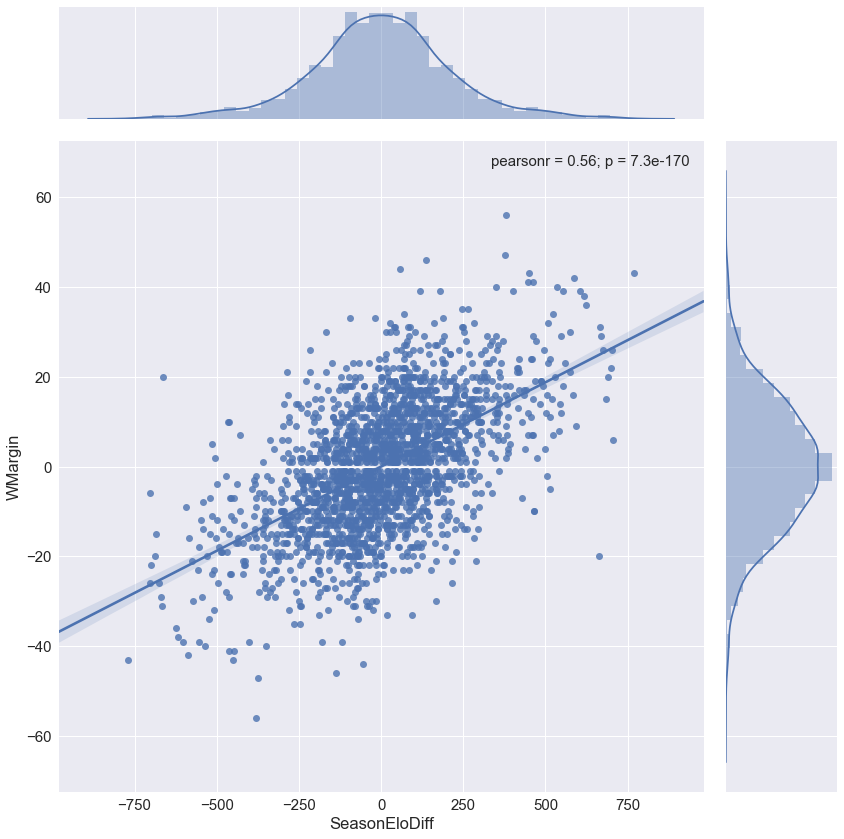

In [11]:
elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)

sns.jointplot(data=elos_tourney, x='SeasonEloDiff', y='WMargin', size=12, kind="reg")

In [12]:
elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)

elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
4183,2018,146,1437,71,1403,59,12,2090.45,1834.38,256.073171
4184,2018,146,1242,85,1181,81,4,1994.26,2010.47,-16.203821
4185,2018,152,1276,69,1260,57,12,1950.42,1728.59,221.831858
4186,2018,152,1437,95,1242,79,16,2090.45,1994.26,96.186820
4187,2018,154,1437,79,1276,62,17,2090.45,1950.42,140.027477


In [17]:
def elo_tune(rs, tourney, Ks, HCAs, x_col='SeasonEloDiff', y_col='WMargin', season_cutoff=2017):
    params = list(itertools.product(Ks, HCAs))
    n_params = len(params)
    scores_all = []
    coefs = []
    for i in range(n_params):
        K, HCA = params[i]
        param_string = "K{}HCA{}".format(K,HCA)
        ### Calculate elos
        elos, rs_preds = elo.season_elos(rs, K, HCA)
        #elos.to_csv(elo_out_dir+"SeasonElos{}.csv".format(param_string))
        
        ### Preprocess elos into [[X][y], [-X],[-y]] form
        elos_tourney = elo.winloss_features(df_teams=tourney, df_feature=elos, feature_cols=['SeasonElo'])
        
        ### Mirror dfs
        elos_tourney = elo.mirror_df(elos_tourney, x=x_col, y=y_col).reset_index(drop=True)
        elos_tourney.to_csv(elo_out_dir+"EloTrain.csv".format(param_string))
        
        ### Evaluate
        scores, coef = elo_lr(elos_tourney, x_col, y_col)
        scores_all.append(scores)
        coefs.append(coef)
        
    return list(zip(params, scores_all)), list(zip(params, coefs))
        
def elo_lr(elos_tourney, x, y, season_cutoff=2017, metrics=[mean_squared_error, explained_variance_score]):
    lr = lm.LinearRegression()
    scores = []
    X_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, x].values.reshape(-1,1)
    X_test = elos_tourney.loc[elos_tourney.Season>=season_cutoff, x].values.reshape(-1,1)
    y_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, y].values.reshape(-1,1)
    y_true = elos_tourney.loc[elos_tourney.Season>=season_cutoff, y].values.reshape(-1,1)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    coef = lr.coef_
    
    for metric in metrics:
        scores.append(metric(y_true, y_pred))
        
    return scores, coef

In [20]:
Ks = np.arange(20, 61, 5)
HCAs = np.arange(100, 141, 10)
#Ks = [20]
#HCAs = [100]
scores, coefs = elo_tune(rs_c, tourney_cr, Ks, HCAs)

In [21]:
scores

[((20, 90), [137.87867718528179, 0.29852864870161133]),
 ((20, 100), [137.83792826872633, 0.29873596282837578]),
 ((20, 110), [137.80452158381726, 0.29890592262842575]),
 ((20, 120), [137.77936375436093, 0.29903391556384351]),
 ((20, 130), [137.76338695230208, 0.29911519911804085]),
 ((20, 140), [137.75753842584066, 0.29914495407249608]),
 ((25, 90), [135.08774591299206, 0.31272778645750343]),
 ((25, 100), [135.01326590278023, 0.31310671084577424]),
 ((25, 110), [134.94625609838673, 0.31344762982612517]),
 ((25, 120), [134.88770230378009, 0.31374552802376443]),
 ((25, 130), [134.83860333065141, 0.31399532388582985]),
 ((25, 140), [134.79996044160706, 0.31419192339018676]),
 ((30, 90), [133.05062739126086, 0.32309182759399835]),
 ((30, 100), [132.95374622546498, 0.3235847200678279]),
 ((30, 110), [132.86474242752766, 0.32403753565675242]),
 ((30, 120), [132.78470035176096, 0.32444475760139979]),
 ((30, 130), [132.71471420922865, 0.32480081899520274]),
 ((30, 140), [132.65587806624731, 0

In [22]:
coefs

[((20, 90), array([[ 0.03907112]])),
 ((20, 100), array([[ 0.03919051]])),
 ((20, 110), array([[ 0.03926437]])),
 ((20, 120), array([[ 0.0392913]])),
 ((20, 130), array([[ 0.03927031]])),
 ((20, 140), array([[ 0.03920094]])),
 ((25, 90), array([[ 0.03713348]])),
 ((25, 100), array([[ 0.03725707]])),
 ((25, 110), array([[ 0.03733947]])),
 ((25, 120), array([[ 0.03737945]])),
 ((25, 130), array([[ 0.03737618]])),
 ((25, 140), array([[ 0.03732928]])),
 ((30, 90), array([[ 0.03566993]])),
 ((30, 100), array([[ 0.03579414]])),
 ((30, 110), array([[ 0.03588014]])),
 ((30, 120), array([[ 0.03592688]])),
 ((30, 130), array([[ 0.03593366]])),
 ((30, 140), array([[ 0.03590019]])),
 ((35, 90), array([[ 0.0344959]])),
 ((35, 100), array([[ 0.03461907]])),
 ((35, 110), array([[ 0.03470623]])),
 ((35, 120), array([[ 0.03475645]])),
 ((35, 130), array([[ 0.03476915]])),
 ((35, 140), array([[ 0.03474414]])),
 ((40, 90), array([[ 0.03351137]])),
 ((40, 100), array([[ 0.03363267]])),
 ((40, 110), array(

In [23]:
elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
4183,2018,146,1437,71,1403,59,12,2090.45,1834.38,256.073171
4184,2018,146,1242,85,1181,81,4,1994.26,2010.47,-16.203821
4185,2018,152,1276,69,1260,57,12,1950.42,1728.59,221.831858
4186,2018,152,1437,95,1242,79,16,2090.45,1994.26,96.186820
4187,2018,154,1437,79,1276,62,17,2090.45,1950.42,140.027477


In [26]:
X_train = elos_tourney.loc[elos_tourney.Season<2016, 'SeasonEloDiff'].values.reshape(-1,1)
X_test = elos_tourney.loc[elos_tourney.Season>=2016, 'SeasonEloDiff'].values.reshape(-1,1)
y_train = elos_tourney.loc[elos_tourney.Season<2016, 'WMargin'].values.reshape(-1,1)
y_true = elos_tourney.loc[elos_tourney.Season>=2016, 'WMargin'].values.reshape(-1,1)

lr = lm.LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
y_pred = lr.predict(X_test)

In [28]:
mean_squared_error(y_true, y_pred)

140.40472490146826

In [36]:
r2_score(y_true, y_pred)

0.3575330607601892

In [39]:
from scipy.stats import pearsonr
r, p = pearsonr(y_true,y_pred)
print(r)

[ 0.60403702]


In [48]:
lr.coef_

array([[ 0.03893915]])

Text(0,0.5,'Margin of Victory')

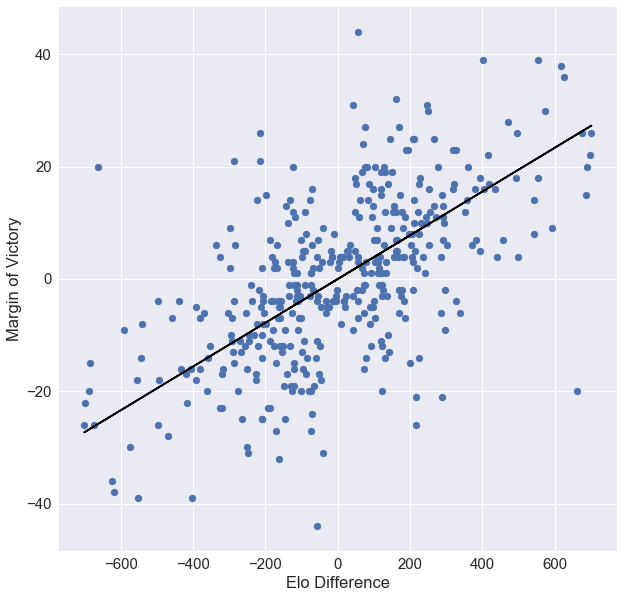

In [56]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
plt.scatter(X_test, y_true)
plt.plot(X_test, y_pred, color='black')
plt.xlabel("Elo Difference")
plt.ylabel("Margin of Victory")

In [58]:
elos_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
0,2003,134,1421,92,1411,84,8,1449.4,1478.29,-28.894400
1,2003,136,1112,80,1436,51,29,1574.61,1488.44,86.172070
2,2003,136,1113,84,1272,71,13,1514.26,1536.52,-22.254773
3,2003,136,1141,79,1166,73,6,1529.64,1613.1,-83.462254
4,2003,136,1143,76,1301,74,2,1532.36,1564.39,-32.027751
